<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars/sem_5/pEbNtDxzx0Q.jpg" height="500" width="500"> 


# R для тервера и матстата

## 4.2 Доверительные интервалы


Данный ноутбук является домашкой по курсу «R для теории вероятностей и математической статистики» (РАНХиГС, 2019). Автор ноутбука [вот этот парень по имени Филипп.](https://vk.com/ppilif) Если у вас для него есть деньги, слава или женщины, он от этого всего не откажется. Ноутбук распространяется на условиях лицензии [Creative Commons Attribution-Share Alike 4.0.](https://creativecommons.org/licenses/by-sa/4.0/) При использовании обязательно упоминание автора курса и аффилиации. При наличии технической возможности необходимо также указать активную гиперссылку на [страницу курса.](https://fulyankin.github.io/R_probability/) На ней можно найти другие материалы. Фрагменты кода, включенные в этот notebook, публикуются как [общественное достояние.](https://creativecommons.org/publicdomain/zero/1.0/)

------------------------

В этой тетрадке мы обсудим почему среднее это очень круто. Мы сделаем переход от точечных оценок к интервальным и попытаемся разобраться как строятся доверительные интервалы, а также обсудим __дельта-метод.__ Итак, план: 

* Схема матстата
* Мощь средних, асимптотические доверительные интервалы через ЦПТ 
* Асимптотический доверительные интервалы для долей
* Дельта-метод - обобщение для ЦПТ 
* Другие союзники, теорема Фишера, точные доверительные интервалы

In [3]:
library("ggplot2")  # Пакет для красивых графиков 
library("grid")     # Пакет для субплотов

# Отрегулируем размер картинок, которые будут выдаваться в нашей тетрадке
library('repr')
options(repr.plot.width=4, repr.plot.height=3)

In [4]:
# Код для строительства картинки. Как обычно, вы не обязаны понимать его, потому что картинки 
# обычно все копипастят из интернета, изменяя в коде кусочки методом тыка. 

# Взят отсюда: http://rstudio-pubs-static.s3.amazonaws.com/58753_13e35d9c089d4f55b176057235778679.html

# Область, которую надо будет закрасить на графике 
limitRange <- function(fun, min, max) {
    function(x) {
        y <- fun(x)
        y[x < min  |  x > max] <- NA
        return(y)
    }
}
  
# Наша функция для закрашивания области порождает функцию. Звучит сложно, но это не так :)
dlimit <- limitRange(dnorm, 0, 2)

# Новая функция будет искать значения плотности нормального распределения только на фиксированном диапазоне
dlimit(-2:4)

[1]         NA         NA 0.39894228 0.24197072 0.05399097         NA         NA

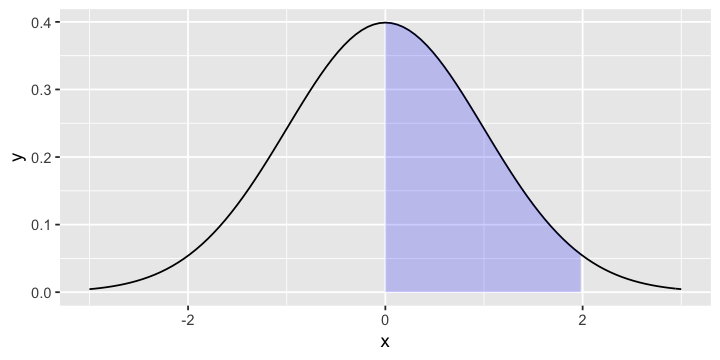

In [5]:
options(repr.plot.width=6, repr.plot.height=3)

dlimit <- limitRange(dnorm, 0, 2) # какую область красим в голубой

ggplot(data.frame(x=c(-3, 3)), aes(x = x))+
       stat_function(fun=dnorm) +  # вся функция 
       stat_function(fun=dlimit, geom="area", fill="blue", alpha=0.2) # область для закраски

# 1. Ещё раз про схему матстата 

Где-то в середине пары, мы нарисовали с вами на доске схему матстата. Давайте воспроизведём её и обсудим ещё раз. 

![КАРТИНКА]( )

__Задача:__ мы уверены, что какая-то штука описывается каким-то распределением с параметром $\theta$. Чтобы понимать эту штуку, нам нужно параметр $\theta$ оценить. __Важно:__ мы препдполагаем, что $\theta$ - константа. 


__Оценивание:__ получить оценку $\hat \theta$ можно разными методами. Например, методом моментов или методом максимального правдоподобия. 


__Точечная оценка:__ Та оценка, которую мы поулчим будет функцией от выборки, то есть слуайная величина. Если у нас есть одна выборка, то будет одна оценка. Если другая выборка, то будет немного другая оценка. На бы хотелось понимать насколько другой может оказаться оценка при новой выборке. Для этого нам нужно знать как эта оценка распределена. Зная распределение оценки, мы сможем посмотреть в каком диапазоне находится $95\%$ её вероятностной массы и сказать, что за края этого диапазона оценка будет вылетать редко. Этот диапозон называется доверительным интервалом. Если он получается коротким, то оценка довольно точная. Если длинным, то не очень.


__Распределение оценки:__ Чтобы построить для оценки параметра доверительный интервал, нужно знать как эта оценка распределена. Многие точечные оценки, которые мы до этого получали, имели вид: $\hat \theta = \bar x$. То есть просто являлись выборочным средним. Среднее это очень крутая штука. Оно по ЦПТ имеет асимптотически нормальное распределение.


__Доверительный интервал:__ Зная, что по ЦПТ 

$$ 
\bar x \sim N\left(\mu, \frac{\sigma^2}{n}\right),
$$ 

мы можем построить для случайной величины $\hat \theta = \bar x$ доверительный интервал

$$
(\bar x - 1.96 \cdot \hat \sigma; \quad \bar x + 1.96 \cdot \hat \sigma).
$$

В этом интервали по свойствам нормального распределения будет находится $95\%$ вероятностной массы. За него оценка при новых выборках будет вылетать очень редко. Если этот интервал короткий, оценка будет точной и прогнозы хорошими. Числа $1.96$ это квантили нормального распределения. Давайте я напомню вам определение квантиля. 

_Определение:_ Квантилем уровня $\alpha$ случайной величины $X$ называется такое значение $z_{\alpha}$ этой случайной величины, что $P(X \le X_{\alpha}) = \alpha$. Если вы ещё не забыли материалы первых пар, квантили можно искать командой `qnorm`.

In [6]:
qnorm(0.025)

[1] -1.959964

Число $-1.96$ это квантиль уровня $2.5\%$. Давайте нарисуем его на графике плотности. 

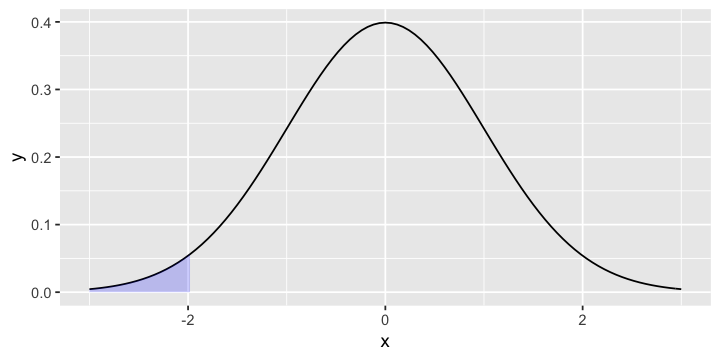

In [7]:
options(repr.plot.width=6, repr.plot.height=3)

dlimit <- limitRange(dnorm, -Inf, qnorm(0.05/2)) # какую область красим в голубой

ggplot(data.frame(x=c(-3, 3)), aes(x = x))+
       stat_function(fun=dnorm) +  # вся функция 
       stat_function(fun=dlimit, geom="area", fill="blue", alpha=0.2) # область для закраски

Величина $\alpha$ называется уровнем значимости. Это ошибка, на которую мы соглашаемся в самом начале эксперимента. Загадывая уровень значимости, мы говорим в скольки случаях из $100$ мы согласны ошибиться. Например, если мы упаковываем в рюкзаеи $100$ парашютов на уровне значимости $5\%$, значит в худшем случае $5$ парашютистов умрут.

В доверительном интервале ваше $\alpha = 0.05$. В принципе мы можем поменять его на любое другое значение и построить другой доверительный интервал. Как именно уровень значимости соотносится с квантиляями мы посмотрим ниже. 

__Что даёт:__ мы знаем точечную оценку, знаем её распределение, понимаем насколько она точная. Когда мы на основе наших оценок строим прогнозы на будущее, мы понимаем насколько точные они. Болеее того, зная распределение оценки, мы можем на его основе отвечать на различные вопросы, то есть проверять гипотезы. Но об этом мы поговорим позже. 

__ЦПТ и вcё?__ Нет. ЦПТ это только одна из теорем, подсказываюших нам какое именно будет распределение у оценки. Есть и другие теоремы, которые оказываются нашими союзниками. Например, делта-метод и теорема Фишера. О них мы тоже сегодня поговорим. 


Перед тем как двигаться дальше, вот вам определение доверительного интервала из лекций: 

__Определение:__  интервал  $(\theta_L; \theta_R)$ называеся доверительным интервалом для параметра $\theta$ с уровнем доверия $\gamma$, если  при бесконечном повторении эксперимента в $100 \cdot \gamma \%$ случаев этот интервал будет накрывать истиное значение параметра $\theta$. При этом $\gamma = 1 - \alpha$. 

# 2. Мощь средних и асимптотические доверительные интервалы



__Ещё раз, ещё раз.__ Среднее хорошо тем, что есть ЦПТ, которая говорит нам, что 

$$ 
\bar x \sim N\left(\mu, \frac{\sigma^2}{n}\right),
$$ 

На основе этого мы можем построить для среднего доверительный интервал. Давайте сделаем это для конкретного примера. Например, для Ульяны, которая любит игру престолов. 

## 2.1 Ульяна смотрит игру престолов

Ульяна любит сериалы! Конечно же Игра Престолов не обошла её стороной. Она смотрит её каждый день. Пусть $X$ - число серий, которое Ульяна просмотрела за день. Понятное дело, что $X \sim Poiss(\lambda)$, где $\lambda$ - интенсивность просмотра. Не забыли же ещё, что случайные величины счётчики можно (но не обязательно) моделировать с помощью распределения Пуассона? 

Ульяне стало интересно с какой интенсивностью она смотрит сериалы, и теперь она хочет построить для $\lambda$ оценку методом моментов, а после доверительный интервал для неё. 

In [8]:
# давайте спросим у Ульяны сколько серий она посмотрела на этой неделе
x <- c(5, 7, 8, 2, 3, 1, 2)

Чтобы получить оценку методом моментов, нам нужно решить уравнение

$$ 
E(X) = \bar x
$$ 

Для распределиния Пуассона, $E(X) = \lambda$. Получается, что $\hat \lambda = \bar x$. Оценка готова. 

In [9]:
lam_hat = mean(x)
lam_hat

[1] 4

Наша оценка это чистое среднее. По ЦПТ оно имеет асимптотически нормальное распределение 

$$
\hat \lambda = \bar x \sim N\left(E(\hat \lambda), Var(\hat \lambda)\right).
$$

Давайте найдём для этой оценки математическое ожидание и дисперсию: 

$$
\begin{aligned}
&E(\hat \lambda) = E(\bar x) =  E \left( \frac{1}{n} \sum_{i=1}^n X_i \right) = \frac{1}{n} \sum_{i=1}^n E(X_i) = \frac{1}{n} \sum_{i=1}^n \lambda = \lambda \\ 
&Var(\hat \lambda) = Var(\bar x) =  Var \left( \frac{1}{n} \sum_{i=1}^n X_i \right) = \frac{1}{n^2} \sum_{i=1}^n Var(X_i) = \frac{\lambda}{n}.
\end{aligned}
$$

Не забываем, что в случае дисперсии мы воспользовались тем, что наблюдения независимы между собой. 

Выходит, что 

$$
\hat \lambda \sim N \left(\lambda, \frac{\lambda}{n} \right).
$$

Есть беда. Она заключается в том, что в дисперсии фигурирует неизвестная нам $\lambda$. Давайте просто заменим её на $\hat \lambda$. Из-за этого ничего не испортится. Почему ничего не испортится, я объясню ниже. Пока что просто смиритесь с этим. Теперь мы знаем, что 

$$
\hat \lambda \sim N \left(\lambda, \frac{\hat \lambda}{n} \right).
$$

и можем построить доверительный интервал. Перепишем выражение выше в терминах стандартного нормального распределения. Для этого пронормируем случайную величину (вычтем среднее) и отскалируем её (поделим на стандартное отклонение):

$$
\frac{\hat \lambda - \lambda}{\sqrt{\frac{\hat \lambda}{n}}} \sim N (0,1)
$$


Получается, что

$$
P \left( -1.96 \le \frac{\hat \lambda - \lambda}{\sqrt{\frac{\hat \lambda}{n}}}  \le 1.96 \right) = 0.95
$$

Если мы возьмём другой уровень значимости, мы можем построить другой доверительный интервал:

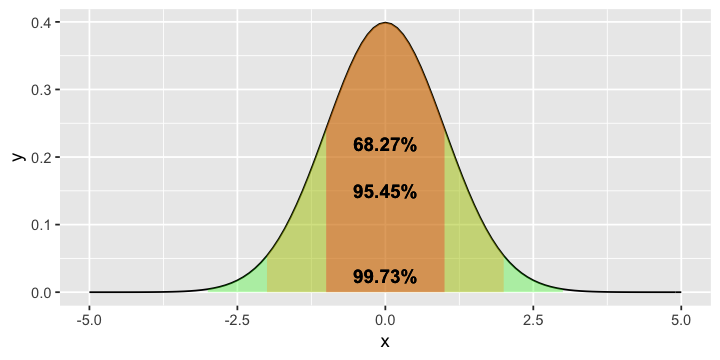

In [10]:
options(repr.plot.width=6, repr.plot.height=3)

dnorm_one_sd <- limitRange(dnorm, -1, 1) 
dnorm_two_sd <- limitRange(dnorm, -2, 2)  
dnorm_three_sd <- limitRange(dnorm, -3, 3)  

ggplot(data.frame(x=c(-5, 5)), aes(x = x))+
        stat_function(fun = dnorm) +  
        stat_function(fun = dnorm_three_sd, geom = "area", fill = "green", alpha = 0.3) +
        stat_function(fun = dnorm_two_sd, geom = "area", fill = "orange", alpha = 0.3) +
        stat_function(fun = dnorm_one_sd, geom = "area", fill = "red", alpha = 0.3) +
        geom_text(x = 0, y = 0.22, size = 4, fontface = "bold",
        label = paste0(round(pnorm(1) - pnorm(-1), 4) * 100, "%")) +
        geom_text(x = 0, y = 0.15, size = 4, fontface = "bold",
        label = paste0(round(pnorm(2) - pnorm(-2), 4) * 100, "%")) +
        geom_text(x = 0, y = 0.025, size = 4, fontface = "bold",
        label = paste0(round(pnorm(3) - pnorm(-3), 4) * 100, "%"))

Обычно пытаются оставить $\frac{\alpha}{2}$ в левом хвосте и столько же в правом хвосте, чтобы интервал получился максимально коротким.  То есть наш интервал имеет вид

$$
P \left( -z_{1 - \frac{\alpha}{2}} \le \frac{\hat \lambda - \lambda}{\sqrt{\frac{\hat \lambda}{n}}}  \le z_{1 - \frac{\alpha}{2}}  \right) = 1 - \alpha.
$$

Можно переписать определение квантиля немного иным языком. Так как $P(X \le X_{\alpha}) = F_{X} (\alpha)$, мы можем написать, что $X_{\alpha} = F^{-1}_X (\alpha)$. Тогда можно записать асимптотический $(1-\alpha)\%$ доверительный интервал для произвольного значения $\alpha$:

$$
F^{-1}_{\hat \lambda}\left(\frac{\alpha}{2}\right) \le \lambda \le F^{-1}_{\hat \lambda}\left(1 -\frac{\alpha}{2}\right)
$$

Вернёмся к нашей ситуации с Ульяной. Заменим $1.96$ на произвольное $z_{1 - \frac{\alpha}{2}$. Доверительный интервал будет выглядеть как

$$
\hat \lambda \pm z_{1 - \frac{\alpha}{2}} \cdot \sqrt{\frac{\hat \lambda}{n}}.
$$

Первый виток теории исчерпан. Строим доверительный интервал: 

In [11]:
alpha = 0.95                   # задаём уровень доверия 
z_alpha = qnorm(1 - alpha/2)   # из нормального распределения автоматически посчитался квантиль

lam_hat = mean(x)                # нашли оценку параметра 
lam_se = sqrt(lam_hat/length(x)) # оценили стандартное отклонение 

# по формулам посчитали границы
lam_left = lam_hat - z_alpha*lam_se
lam_right = lam_hat + z_alpha*lam_se
cat('Доверительный интервал:', lam_left, lam_right)

Доверительный интервал: 3.952598 4.047402

## 2.2 У Ульяны биполярочка 

Повышаем планочку абстракции. Пусть теперь у Ульяны биполярочка. Она себе завела воображаемого друга по имени Таня. Теперь они смотрят сериалы вдвоём. Каждая со своей интенсивностью $\lambda_i$. 

Ульяна считает, что она опережает Таню по интенсивности просмотра. Нужно построить доверительный интервал для разности $\lambda_1 - \lambda_2$ и понять правда ли, что Ульяна впереди. Для простоты будем считать, что Ульяна и Таня смотрят сериалы независимо друг от друга. 

In [28]:
x <- c(5, 7, 8, 2, 3, 1, 2)  # Ульяна
y <- c(4, 8, 9, 1, 2, 2, 2)  # Таня 

Оценка для Ульяны это $\hat \lambda_1 = \bar x$. Оценка для Тани это $\hat \lambda_2 = \bar y$. Два средних. Построены по независимым выборкам. Для обоих работает ЦПТ. Выходит, что 

\begin{equation*}
\begin{aligned}
\hat \lambda_1 = \bar x  \sim N \left(\lambda_1, \frac{\hat \lambda_1}{n_1} \right)\\
\hat \lambda_2 = \bar y  \sim N \left(\lambda_2, \frac{\hat \lambda_2}{n_2} \right).
\end{aligned} 
\end{equation*}

Математическое ожидание и дисперсию мы выше посчитали. Теперь нас интересует распределение случайной величины $\hat \lambda_1 - \hat \lambda_2$. Мы помним из курса по теории вероятностей, что сумма (ну или разность) нормально распределённых случайных величин снова нормальна. Давайте найдём её характеристики. 

$$
\begin{aligned}
& E(\hat \lambda_1 - \hat \lambda_2) = \lambda_1 - \lambda_2 \\
& Var(\hat \lambda_1 - \hat \lambda_2) = Var(\hat \lambda_1) + Var(\hat \lambda_2) = \frac{\lambda_1}{n_1} + \frac{\lambda_2}{n_2} 
\end{aligned}
$$

Получается, что 

$$
\hat \lambda_1 - \hat \lambda_2 \sim N \left( \lambda_1 - \lambda_2, \frac{\hat \lambda_1}{n_1} + \frac{\hat \lambda_2}{n_2} \right).
$$

Отсюда можно легко найти доверительный интервал для разности интенсивностей: 

$$
\hat{\lambda}_1 - \hat{\lambda}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{\lambda}_1}{n_1} + \frac{\hat{\lambda}_2}{n_2}}
$$

Построим его. 

In [31]:
alpha = 0.05
z_alpha = qnorm(1 - alpha/2)

diff = mean(x) - mean(y)
diff_se = sqrt(mean(x)/length(x) + mean(y)/length(y))

left = diff - z_alpha*diff_se
right = diff + z_alpha*diff_se
cat('Доверительный интервал:', left, right)

Доверительный интервал: -2.09529 2.09529

Доверительный интервал покрывает ноль. Это означает, что Ульяна и аня смотрят сериал с одинаковой интенсивностью. Угадайте как часто мы сделаем ошибку, утверждая это? Правильно! В $5\%$ случаев. Фактически мы с вами только что проверили на уровне значимости $5\%$ гипотезу о равенстве средних.

## 2.3 Нюанс с заменой $\lambda$ на $\hat \lambda$

Выше, в пункте $2.1$, мы написали, что по ЦПТ 



# 3. Асимптотические доверительные интервалы для долей

## 3.1 Интервал для одной доли

Давайте повторим ровно те же рассуждения, что и выше, но уже для случая долей. Пусть у нас есть какой-то продукт. Например, кофе. Нам хотелось бы оценить какой доле людей нравится наш кофе. Введём случайную величину: 

$$
X = \begin{cases} 1, \text{ человеку нравится} \\ 0, \text{ иначе} \end{cases}.
$$

Такая случайная величина имеет распределение Бернулли с параметром $p$ - вероятностью, что люди любят наш кофе, $ X \sim Ber(p)$.

Измерить любовь к кофе можно с помощью опроса. Если в нём примут участие $n$ человек, то на выходе мы получим выборку, состоящую из нулей и единиц. Оценкой любви к кофе будет выборочная доля:

$$
\hat p = \frac{1}{n} \sum_{i=1}^n x_i.
$$

По сути, эта оценка является выборочным средним. Значит мы можем воспользоваться ЦПТ и сказать, что: 

$$
\hat p \sim N\left(E(X), \frac{Var(X)}{n}\right).
$$

Для случайной величины, имеющей распределение Бернулли $E(X) = p$, $Var(X) = p \cdot (1-p)$. Значит 

$$
\hat p \sim N \left(p, \frac{p \cdot (1-p)}{n}\right).
$$

Либо, иными словами говоря 

$$ 
\frac{ \hat p - p}{\sqrt{\frac{p \cdot (1-p)}{n}}} \sim N(0,1)
$$



В параметрах распределения находится $p$, которое мы не знаем. Мы можем оценить их, подставив туда вместо $p$ его оценку. Тогда распределение параметра будет для нас полностью известно. Теперь, если от нас требуют $95%$ доверительный интервал, мы можем сказать, что 

$$
P\left( -1.96 \le \frac{ \hat p - p}{\sqrt{\frac{\hat p \cdot (1 - \hat p)}{n}}} \le 1.96\right) = 0.95.
$$

Немного раскрываем неравенство и получаем, что: 

$$
P\left(\hat p - 1.96 \sqrt{\frac{\hat p \cdot (1 - \hat p)}{n}} \le p \le \hat p + 1.96 \sqrt{\frac{\hat p \cdot (1 - \hat p)}{n}} \right) = 0.95.
$$

Это выражение и будет $95\%$ доверительным интервалом для доли любителей кофе. Если мы начнём собирать выборку по кофеманам и выясним, что для $n=10$, $\hat p = 0.6$, доверительный интервал окажется равен $(0.29; 0.91)$. Если окажется, что для $n=100$, $\hat p = 0.44$, то доверительный интервал окажется равен $(0.34; 0.54)$. 

Для второй ситуации он оказался намного уже. При сотне наблюдений наша уверенность в оценке увеличилась. Обратите внимание, что при $n=10$ мы поулчили оценку $0.6$. Доверительный интервал при этом не исключал возможность того, что истиный параметр равен $0.44$. В то же самое время, при сотне наблюдений вероятность того, что истиное значение параметра равно $0.6$ довольно сильно упала. Вот такие вот доверительные интервалы. 


Отлично! Давайте сгенерируем немного данных и построим доверительных интервалов для долей.  Зафиксируем зерно генерации (вспомните зачем это делается) и создадим огромную генеральную совокупность. Давайте считать, что это генеральная совокупность состоит из любителей кофе. Один означает, что человек любит кофе, нолик что нет. Всего в городе живет $100000$ человек.

In [13]:
set.seed(42) # помните, что seed нужен для воспроизводимости? 
x_general = sample(x = c(0,1), prob = c(0.3,0.7), size = 10^5, replace = TRUE)

Представим себе, что мы не знаем что находится в генеральной совокупности. Две строчки выше за нас запустила природа. И не показала их нам. 

Мы, как исследователи, понимаем, что опрашивать каждого из ста тысяч дорого. Но долю любетелей кофе оценить хотелось бы. Поэтому мы решаем опросить $100$ случайных человек. 

In [14]:
set.seed(42)
x_sample = sample(size = 100, x_general) # случайная выборка из генеральной совокупности

Вот у нас и появилась выборка. Мы можем получить точечную оценку доли, напрмер, воспользовавшись методом максимального правдоподобия. Это будет среднее. 

In [15]:
mean(x_sample)

[1] 0.67

При этом реальное, посчитанное по всей генеральной совокупности среднее будет

In [16]:
mean(x_general)

[1] 0.69773

Мы не знаем его. У нас есть точечная оценка и мы хотим построить по ней доверительный интервал. Мы знаем, что 

$$
\hat p \sim N \left(p, \frac{p \cdot (1-p)}{n}\right).
$$

Значит доверительный интервал для доли будет выглядеть как:

$$
\hat{p}\pm z_{1-\frac{\alpha}{2}} \sqrt{\frac{\hat{p}\left(1-\hat{p}\right)}{n}}
$$

Дело за малым, найти интервал:

In [17]:
p_hat = mean(x_sample) # оценка
p_hat

sd_p = sqrt(p_hat*(1-p_hat)/100) # стандартное отклонение оценки 
sd_p

[1] 0.67

[1] 0.04702127

In [18]:
# по формуле расчитываем интервал: 

p_left  = p_hat - qnorm(1-0.05/2)*sd_p
p_right = p_hat + qnorm(1-0.05/2)*sd_p
cat('Параметр p с вероятностью 95% лежит между',p_left, 'и',p_right, '\n')
cat('Длина интервала:', p_right-p_left)

Параметр p с вероятностью 95% лежит между 0.57784 и 0.76216 
Длина интервала: 0.18432

Ясное дело, что если мы возьмём в выборку большее число респондентов, интервал станет уже. Давайте пронаблюдаем вместо $100$ целую $1000$ людей. 

In [19]:
set.seed(42)
x_sample = sample(size = 1000, x_general)

p_hat = mean(x_sample)
sd_p = sqrt(p_hat*(1-p_hat)/1000)

p_left  = p_hat - qnorm(1-0.05/2)*sd_p
p_right = p_hat + qnorm(1-0.05/2)*sd_p
cat('Параметр p с вероятностью 95% лежит между',p_left, 'и',p_right, '\n')
cat('Длина интервала:', p_right-p_left)

Параметр p с вероятностью 95% лежит между 0.6439243 и 0.7020757 
Длина интервала: 0.05815131

В связи с этим может возникнуть вопрос: а какое количество наблюдений надо взять, чтобы интервал получился заданной ширины? К счастью это не проблема. Ширину доверительного интервала можно вычислить как:

$$
p_{right} - p_{left} = 2 \cdot z_{1-\frac{\alpha}{2}} \sqrt{\frac{\hat{p}\left(1-\hat{p}\right)}{n}}
$$

Отсюда можно посчитать число наблюдений, которое нам необходимо для строительства доверительного интервала фиксированной ширины:

$$
n = \frac{4 z^2 \cdot p \cdot (1-p)}{(p_{left} - p_{right})^2}
$$

Давайте проговорим как это интерпретировать. Мы можем заранее заказать точность оценки $p_{right} - p_{left}$ и ошибку, которую мы согласны допустить $\alpha$. И отталкиваясь от этих двух вещей понять сколько нам нужно наблюдений. Запомните этот момент, он снова всплывёт в проверке гипотез. 

In [23]:
# функция, которая это посчитает :) 

sample_len <- function(alpha, len){
    return(4*qnorm(1 - alpha/2)^2*p_hat*(1 - p_hat)/len^2)
    }

sample_len(0.05, 0.1)  # для длины 0.1  и ошибки 0.05 нужно 338 наблюдения
sample_len(0.05, 0.05) # для длины 0.05 и ошибки 0.05 нужно 1352 наблюдения
sample_len(0.1, 0.05)  # для длины 0.05 и ошибки 0.1  нужно 1352 наблюдения

[1] 338.1575

[1] 1352.63

[1] 952.6586

Ясное дело, что можно сделать всё это в рамках какого-нибудь пакета. Например, в пакете `binom` присутствует довольно много разных методов построения доверительных интервалов для долей. 

In [24]:
library('binom')
binom.confint(sum(x_sample), length(x_sample), conf.level = 0.95, methods = 'asymptotic')

method,x,n,mean,lower,upper
asymptotic,673,1000,0.673,0.6439243,0.7020757


С помощью этого же пакета можно выяснить какой будет ширина доверительного интервала для доли при фиксированном числе наблюдений.

In [25]:
binom.length(p = p_hat, n = c(10,50,100,1000), methods = 'asymptotic')

method,n,p,length
asymptotic,10,0.673,0.54172133
asymptotic,50,0.673,0.25704406
asymptotic,100,0.673,0.18283545
asymptotic,1000,0.673,0.05811825


Какие другие методы есть в пакете? Например, есть доверительный интервал Уилсона. Это улучшенный доверительный интервал, который даёт качественные оценки на границах. При доле близкой к нулю или единице. Он не даёт пробить границу. Также неплох для малых выборок.

$$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{
z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$$ 


In [26]:
set.seed(42)
x_sample = sample(x = c(0,1), prob = c(0.01,0.99), size = 100, replace = TRUE)

binom.confint(sum(x_sample), length(x_sample), conf.level = 0.95, methods = c('asymptotic', 'wilson'))

method,x,n,mean,lower,upper
asymptotic,100,100,1,1.0000000,1
wilson,100,100,1,0.9630065,1


In [27]:
mean(x_sample)

[1] 1

Видим, что обычный асимптотический интервал немножечко нас подвёл, а интервал Уилсона оказался устойчив к проблемам с выборкой, в которую попали одни единицы.

## 3.2 Интервал для двух долей.

Выше мы с вами выяснили как построить доверительный интервал для доли. Иногда требуется сделать это для разности долей. Представим себе товар, который нужно рекламировать. Для этих целей используется рекламный баннер. Если появляется новый баннер, который кажется более красивым, то возникает необходимость проверить какой из баннеров лучше, а также понять насколько новый баннер красивее первого. 

В нашем распоряжении есть выборка из кликов по первому банеру, $X$ и по второму банеру, $Y$.

$$
\begin{aligned}
X_1, \ldots, X_{n_1} \sim iid \hspace{1mm} Bern(p_1) \\
Y_1, \ldots, Y_{n_2} \sim iid \hspace{1mm} Bern(p_1)
\end{aligned}
$$

Мы можем найти оценки для обеих вероятностей через средние. Оба средних будут иметь асимптотически нормальные распределения со своими параметрами: 

$$
\begin{aligned}
\hat p_1 = \bar x \sim N \left(p_1, \frac{p_1(1-p_1)}{n_1} \right)\\
\hat p_2 = \bar y \sim N \left(p_2, \frac{p_2(1-p_2)}{n_2} \right)
\end{aligned}
$$

Если выборки независимы, разность долей будет тоже иметь асимптотически нормальное распределение! Его параметры довольно легко найти: 

$$
\hat p_1 - \hat p_2  \sim N \left(p_1 - p_2, \frac{p_1(1-p_1)}{n_1} + \frac{p_2(1-p_2)}{n_2} \right).
$$

Отсюда можно легко найти доверительный интервал для разности долей: 

$$
\hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}
$$

In [29]:
z = qnorm(1 - 0.05/2)
p1 = 0.6  # Возьмём цифры просто из головы
p2 = 0.5  # Ясное дело, их можно посчитать по выборке
n1 = 10
n2 = 100

sd = sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
left  = (p1 - p2) - z*sd
right = (p1 - p2) + z*sd

cat('Разность p1-p2 с вероятностью 95% лежит между', left, 'и', right, '\n')
cat('Длина интервала:', right - left)

Разность p1-p2 с вероятностью 95% лежит между -0.219059 и 0.419059 
Длина интервала: 0.638118

__Важно:__ всё, что было написано выше, работает только в ситуации, когда выборки $X$ и $Y$ независимы друг от друга. Если между ними ест взаимосвязь (например, оба баннера кликали одни и те же люди), то доверительные интервалы строят немного по другой методике, учитывающей эту взаимосвязь. Но об этом мы будем разговаривать чуть позже. 

# 4. Дельта-метод 

## 4.1 Зачем? 



## 4.2 Дельта-Ульяна

# 5. Кто наши союзники? 

# 6. Точные доверительные интервалы 

# 7.  Недвижимая недвижимость! 


В [табличке](https://yadi.sk/i/hDxMJ0fw3VSDmu) лежит информация о стоимости квартир в Москве и о основных параметрах этих квартир.

__Описание переменных:__

```
n – номер квартиры по порядку
price – цена квартиры в $1000
totsp – общая площадь квартиры, кв.м.
livesp жилая площадь квартиры, кв.м.
kitsp – площадь кухни, кв.м.
dist – расстояние от центра в км.
metrdist – расстояние до метро в минутах
walk – 1 – пешком от метро, 0 – на транспорте
brick 1 – кирпичный, монолит ж/б, 0 – другой
floor 1 – этаж кроме первого и последнего, 0 – иначе.
code – число от 1 до 8, при помощи которого мы группируем наблюдения по
подвыборкам:
1. Наблюдения сгруппированы на севере, вокруг Калужско-Рижской линии
метрополитена
2. Север, вокруг Серпуховско-Тимирязевской линии метрополитена
3. Северо-запад, вокруг Замоскворецкой линии метрополитена
4. Северо-запад, вокруг Таганско-Краснопресненской линии метрополитена
5. Юго-восток, вокруг Люблинской линии метрополитена
6. Юго-восток, вокруг Таганско-Краснопресненской линии метрополитена
7. Восток, вокруг Калиниской линии метрополитена
8. Восток, вокруг Арбатско-Покровской линии метрополитена
```

In [55]:
library('dplyr')
library('ggplot2')

In [56]:
df = read.csv('/Users/fulyankin/Yandex.Disk.localized/R/R_prob_data/flat.csv', sep='\t')
head(df)

n,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
1,81,58,40,6,12.5,7,1,1,1,3
2,75,44,28,6,13.5,7,1,0,1,6
3,128,70,42,6,14.5,3,1,1,1,3
4,95,61,37,6,13.5,7,1,0,1,1
5,330,104,60,11,10.5,7,0,1,1,3
6,137,76,50,9,11.0,7,1,1,1,8


__[a]__ Построить $99\%$ асимптотический доверительный интервал для средней стоимости квартиры. Построить точный доверительный интервал для средней стоимости квартиры. Какой из них оказался короче? Почему? 

Асимптотический доверительный интервал: 

$$
\bar x \pm z_{1 - \frac{\alpha}{2}} \cdot \sqrt{\frac{\hat s^2}{n}}.
$$

Точный доверительный интервал: 

$$
\bar x \pm t_{1 - \frac{\alpha}{2}} \cdot \sqrt{\frac{\hat s^2}{n}}.
$$

Вспоминаем про трубочку и пакет `dplyr`. Вы его уже однажды использовали в домашке при анализе дней рождений. 

In [77]:
df %>% summarise(x_bar = mean(price), 
                 s = sd(price)) 

x_bar,s
127.4966,51.87822


Мы берём таблицу `df` и применяем к ней команду `summarise`, делающую агрегацию для конкретных стобиков. На выходе получается табличка с посчитанными статистиками. Чуть ниже мы к этой схеме прикрутим ещё и `group by`. Точно также можно посчитать доверительные интервалы: асимптотический

In [140]:
alpha = 0.01
z_alpha = qnorm(1 - alpha/2)

df %>% summarise(left = mean(price) - z_alpha * (sd(price) / sqrt(length(price))),
                 right = mean(price) + z_alpha * (sd(price) / sqrt(length(price))))

left,right
124.538,130.4552


и точный.

In [141]:
alpha = 0.01
t_alpha = qt(df=nrow(df) - 1, 1 - alpha/2)

df %>% summarise(left = mean(price) - t_alpha * (sd(price) / sqrt(length(price))),
                 right = mean(price) + t_alpha * (sd(price) / sqrt(length(price))))

left,right
124.5352,130.4579


__[b]__ Построить $99\%$ асимптотические доверительные интервалы для всех районов. В какие из них попало общее среднее? Постройте красивую визулизацию.

Та же самая трубочка, но уже с `group by`:

In [147]:
df %>%  group_by(code)  %>% summarise(x_bar = mean(price), 
                                       s = sd(price)) 

code,x_bar,s
1,134.4118,49.61951
2,110.3163,29.51845
3,148.2464,70.57356
4,148.6938,73.65683
5,115.7798,31.50748
6,109.9650,32.97659
7,114.2301,33.89749
8,136.7444,48.63926


In [148]:
df_conf = df %>%  group_by(code)  %>% summarise(left = mean(price) - z_alpha * (sd(price) / sqrt(length(price))),
                                      right = mean(price) + z_alpha * (sd(price) / sqrt(length(price))))  

df_conf

code,left,right
1,126.6621,142.1615
2,105.1308,115.5018
3,138.4594,158.0334
4,135.5701,161.8175
5,111.3522,120.2073
6,104.6664,115.2635
7,108.4220,120.0381
8,127.4061,146.0827


Давайте визуализируем этот результат. Для этого сделаем в табличке ещё один столбик. В нём будет лежать ответ на вопрос: "А находится ли общее среднее в доверительном интервале?" 

In [149]:
total_mean = mean(df$price)
print(total_mean)

df_conf <- df_conf %>%
  mutate(capture_mu = ifelse(left < total_mean & right > total_mean, "yes", "no"))

df_conf

[1] 127.4966


code,left,right,capture_mu
1,126.6621,142.1615,yes
2,105.1308,115.5018,no
3,138.4594,158.0334,no
4,135.5701,161.8175,no
5,111.3522,120.2073,no
6,104.6664,115.2635,no
7,108.4220,120.0381,no
8,127.4061,146.0827,yes


Забавно, но оно не лежит ни в одном доверительном интервале по районам. Районы получаются слишком разными в плане своего ценообразования. 

In [150]:
ci_data <- data.frame(ci_id = df_conf$code,  # по оси y будем откладывать id района
                      capture_mu = df_conf$capture_mu, # раскраска для интервалов
                      ci_bounds = c(df_conf$left, df_conf$right) # по оси x интервалы (2 точки для кажого id)
                      )
head(ci_data)

ci_id,capture_mu,ci_bounds
1,yes,126.6621
2,no,105.1308
3,no,138.4594
4,no,135.5701
5,no,111.3522
6,no,104.6664


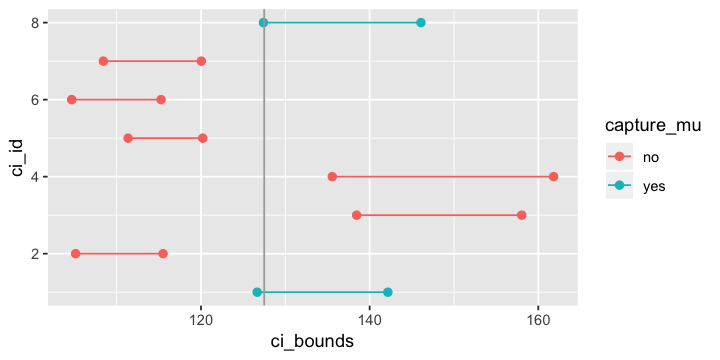

In [151]:
ggplot(data = ci_data, aes(x = ci_bounds, y = ci_id, 
                           
        # group говорит, что для каждого ci_id свой график 
        # color говорит, что раскрашивать интервалы надо в зависимоси от колонки capture_mu
        # если общее среднее лежит в интервале, интервал синий, если нет - красный                  
        group = ci_id, color = capture_mu)) +

  # рисуем в начале и конце интервала точки 
  geom_point(size = 2) + 

  # соединяем эти точки линией
  geom_line() +

  # прорисовываем на картинке общее среднее по выборке в виде серой черты 
  geom_vline(xintercept = total_mean, color = "darkgray")

__[c]__ 

__[d]__ 

взднк пкщгз 